
... ***CURRENTLY UNDER DEVELOPMENT*** ...


## RBFs reconstruction of historical and synthetic data

inputs required: 
  * Historical offshore waves
  * Synthetic offshore waves - emulator output
  * Sea and swell SWAN simulated  cases from ***Notebook 02_02***

in this notebook:
  * RBF reconstruction historical and simulated storms
  * Generation of hourly nearshore waves with Intradaily Hydrographs
  * Validation: syntethic and historical nearshore waves histograms



### Workflow:

<div>
<img src="resources/nb02_03.png" width="400px">
</div>



In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Reconstruction, RBF_Validation
from teslakit.waves import Aggregate_WavesFamilies, AWL, Intradaily_Hydrograph
from teslakit.climate_emulator import Climate_Emulator

from teslakit.plotting.waves import Plot_Waves_Histogram_FitSim



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('ROI')

# Load Climate Emulator (storms data inside)
CE = Climate_Emulator(db.paths.site.EXTREMES.climate_emulator)
CE.Load()

n_sims_DWTs = 10


In [3]:
# input files: dataset, subset (MDA classification), and target (SWAN simulations output)

# sea 
wvs_sea_dataset_sim = db.Load_NEARSHORE_SIM_sea()
wvs_sea_dataset_hist = db.Load_NEARSHORE_HIST_sea()
wvs_sea_subset = db.Load_NEARSHORE_MDA_sea()
wvs_sea_target = db.Load_NEARSHORE_TARGET_sea()

# swells 
wvs_swell_dataset_sim = db.Load_NEARSHORE_SIM_swell()
wvs_swell_dataset_hist = db.Load_NEARSHORE_HIST_swell()
wvs_swell_subset = db.Load_NEARSHORE_MDA_swell()
wvs_swell_target = db.Load_NEARSHORE_TARGET_swell()

# keep datasets n_sim column
sea_n_sim = wvs_sea_dataset_sim['n_sim']
swl_n_sim = wvs_swell_dataset_sim['n_sim']


# remove nans (if any) from subset and target
def fix_target_nans(subset, target):
    'remove NaN data indexes from subset and target. RBF does not handle NaNs'
    
    r_nan = target.isnull().any(axis=1)  # find any row with nans

    if r_nan.any():
        # log
        print('remove nan data found at target:')
        print(target[r_nan])
        
        # clean data
        target = target[~r_nan]
        subset = subset[~r_nan]
        
    return subset, target

wvs_sea_subset, wvs_sea_target = fix_target_nans(wvs_sea_subset, wvs_sea_target)
wvs_swell_subset, wvs_swell_target = fix_target_nans(wvs_swell_subset, wvs_swell_target)


# ensure dataset and subset have same variables and column order
vns_ds = ['hs', 'tp', 'dir']

wvs_sea_dataset_sim = wvs_sea_dataset_sim[vns_ds].values
wvs_sea_dataset_hist = wvs_sea_dataset_hist[vns_ds].values
wvs_sea_subset = wvs_sea_subset[vns_ds].values

wvs_swell_dataset_sim = wvs_swell_dataset_sim[vns_ds].values
wvs_swell_dataset_hist = wvs_swell_dataset_hist[vns_ds].values
wvs_swell_subset = wvs_swell_subset[vns_ds].values


# select target variables
vns_tgt = ['Hsig', 'TPsmoo', 'Dir']

wvs_sea_target = wvs_sea_target[vns_tgt].values
wvs_swell_target = wvs_swell_target[vns_tgt].values


remove nan data found at target:
           lon     lat  Hsig  Tm02  Dir  Dspr  TPsmoo
case                                                 
50    167.4679  9.4165   0.0   NaN  NaN   NaN     NaN


In [4]:
# RBF settings

# subset - scalar / directional indexes
ix_scalar_subset = [0,1]      # scalar (hs, tp)
ix_directional_subset = [2]   # directional (dir)

# target - scalar / directional indexes
ix_scalar_target = [0,1]      # scalar (Hsig, Tpsmoo, Dir)
ix_directional_target = [2]   # directional (Dir)


# RBF wrappers 
def RBF_Reconstruction_sea(dataset_input):
    
    return RBF_Reconstruction(
    wvs_sea_subset, ix_scalar_subset, ix_directional_subset,
    wvs_sea_target, ix_scalar_target, ix_directional_target,
    dataset_input)

def RBF_Reconstruction_swell(dataset_input):
    
    return RBF_Reconstruction(
    wvs_swell_subset, ix_scalar_subset, ix_directional_subset,
    wvs_swell_target, ix_scalar_target, ix_directional_target,
    dataset_input)

def RBF_Reconstruction_families(data):
   
    # sea
    vs = ['sea_Hs', 'sea_Tp', 'sea_Dir']
    data_sea = data[vs].dropna()
    data_sea.drop(data_sea[(data_sea['sea_Dir'] >= 360)].index, inplace=True)  # fix sea_Dir >> 360 bug    
    rec_sea = RBF_Reconstruction_sea(data_sea.values)
    rec_sea = pd.DataFrame(data=rec_sea, columns=vs, index=data_sea.index)

    # swell 1
    vs = ['swell_1_Hs', 'swell_1_Tp', 'swell_1_Dir']
    data_swl_1 = data[vs].dropna()
    rec_swl_1 = RBF_Reconstruction_swell(data_swl_1.values)
    rec_swl_1 = pd.DataFrame(data=rec_swl_1, columns=vs, index=data_swl_1.index)

    # swell 2
    vs = ['swell_2_Hs', 'swell_2_Tp', 'swell_2_Dir']
    data_swl_2 = data[vs].dropna()
    rec_swl_2 = RBF_Reconstruction_swell(data_swl_2.values)
    rec_swl_2 = pd.DataFrame(data=rec_swl_2, columns=vs, index=data_swl_2.index)
    
    # join nearshore reconstructed data and parse to xarray.Dataset
    rec_waves = pd.concat([rec_sea, rec_swl_1, rec_swl_2], axis=1)

    # return pandas.dataframe
    return rec_waves
     


## RBF Reconstruct SEA Waves

In [5]:
# --------------------------------------
# RBF Interpolation

# Simulated SEA waves
#sea_rec_sim = RBF_Reconstruction_sea(wvs_sea_dataset_sim)
#df_sea_recon_sim = pd.DataFrame(data=sea_rec_sim, columns=vns_tgt)
#df_sea_recon_sim['n_sim'] = sea_n_sim  # keep n_sim value

# Historical SEA waves
#sea_rec_hist = RBF_Reconstruction_sea(wvs_sea_dataset_hist)
#df_sea_recon_hist = pd.DataFrame(data=sea_rec_hist, columns=vns_tgt)

# store data
#db.Save_NEARSHORE_RECONSTRUCTION_SIM_sea(df_sea_recon_sim)
#db.Save_NEARSHORE_RECONSTRUCTION_HIST_sea(df_sea_recon_hist)



## RBF Reconstruct SWELL Waves

In [6]:
# --------------------------------------
# RBF Interpolation

# Simulated SWELL waves
#swl_rec_sim = RBF_Reconstruction_swell(wvs_swell_dataset_sim)
#df_swl_recon_sim = pd.DataFrame(data=swl_rec_sim, columns=vns_tgt)
#df_swl_recon_sim['n_sim'] = swl_n_sim  # keep n_sim value

# Historical SWELL waves
#swl_rec_hist = RBF_Reconstruction_swell(wvs_swell_dataset_hist)
#df_swl_recon_hist = pd.DataFrame(data=swl_rec_hist, columns=vns_tgt)

# store data
#db.Save_NEARSHORE_RECONSTRUCTION_SIM_swell(df_swl_recon_sim)
#db.Save_NEARSHORE_RECONSTRUCTION_HIST_swell(df_swl_recon_hist)



## RBF Reconstruct Historical hourly data

In [7]:
# Load hourly historical data
HIST_C_h = db.Load_HIST_Complete_hourly()

# Reconstruct waves by families
WVS_HIST_rec = RBF_Reconstruction_families(HIST_C_h.to_dataframe())
WVS_HIST_rec = xr.Dataset.from_dataframe(WVS_HIST_rec)

# aggregate nearshore variables (Tp from max. energy waves family)
WVS_a = Aggregate_WavesFamilies(WVS_HIST_rec, a_tp = 'quadratic')  # TODO: max energy
WVS_HIST_rec = xr.merge([WVS_HIST_rec, WVS_a])

# calculate nearshore AWL
WVS_HIST_rec['AWL'] = AWL(WVS_HIST_rec.Hs, WVS_HIST_rec.Tp)

# store historical hourly nearshore waves reconstruction
db.Save_NEARSHORE_RECONSTRUCTION_HIST_hourly(WVS_HIST_rec)


ix_scalar: 0,  optimization: 40.92 | interpolation: 20.76
ix_scalar: 1,  optimization: 92.46 | interpolation: 16.59
ix_directional: 2,  optimization: 99.71 | interpolation: 33.48
ix_scalar: 0,  optimization: 38.83 | interpolation: 26.40
ix_scalar: 1,  optimization: 79.25 | interpolation: 27.74
ix_directional: 2,  optimization: 75.62 | interpolation: 53.09
ix_scalar: 0,  optimization: 39.02 | interpolation: 29.53
ix_scalar: 1,  optimization: 79.38 | interpolation: 32.98
ix_directional: 2,  optimization: 74.93 | interpolation: 59.19



## RBF Reconstruct Simulation storms and generate hourly data

In [8]:
# load all climate emulator storms simulations
WVS_SIM = CE.LoadSim_All()
    
# reconstruct waves by families
WVS_SIM_rec = RBF_Reconstruction_families(WVS_SIM)
WVS_SIM_rec['n_sim'] = WVS_SIM.n_sim
WVS_SIM_rec['time'] = WVS_SIM.time


ix_scalar: 0,  optimization: 45.02 | interpolation: 52.70
ix_scalar: 1,  optimization: 100.03 | interpolation: 54.66
ix_directional: 2,  optimization: 131.58 | interpolation: 105.95
ix_scalar: 0,  optimization: 45.83 | interpolation: 137.15
ix_scalar: 1,  optimization: 93.62 | interpolation: 140.02
ix_directional: 2,  optimization: 87.74 | interpolation: 270.21
ix_scalar: 0,  optimization: 45.41 | interpolation: 148.26
ix_scalar: 1,  optimization: 92.43 | interpolation: 154.73
ix_directional: 2,  optimization: 89.10 | interpolation: 327.13


In [9]:
def waves_hourly(CE, WVS_SIM_rec, n_sim_ce=0):
    '''
    Generate nearshore hourly simulation output. 
    
    - aggregate nearshore waves storms
    - generate hourly hydrographs
    - calculates AWL
    
    return xarray.Dataset with dims: n_sim (DWTs-WVs), time (hourly)
    '''
    
    # iterate simulations
    ls_hy = []
    for n in range(n_sims_DWTs):
        
        # select simulation
        WVS_SIM_rec_n = WVS_SIM_rec.loc[WVS_SIM_rec['n_sim'] == n]

        # aggregate nearshore variables (Tp from max. energy waves family)
        wvs_agr = Aggregate_WavesFamilies(WVS_SIM_rec_n, a_tp = 'quadratic')  # TODO: max_energy
        
        # Load TCs storm data from climate emulator
        _, TCS_sim, _ = CE.LoadSim(n_sim = n)    
        TCS_sim = TCS_sim.isel(n_sim = n_sim_ce).copy()        
        
        # calculate intradaily hourly hydrographs for simulated storms
        hy = Intradaily_Hydrograph(wvs_agr, TCS_sim)
        
        ls_hy.append(hy)
        
        print('Intradaily Hydrograph SIM nº {0} done.'.format(int(n)))

        
    # combine hourly simulations
    hy = xr.concat(ls_hy, 'n_sim')

    # calculate hourly Atmospheric Water Level
    hy['AWL'] = AWL(hy.Hs, hy.Tp)
 
    return hy


# generate intradaily hydrographs
WVS_SIM_rec_h = waves_hourly(CE, WVS_SIM_rec)  

# store hourly nearshore waves data
db.Save_NEARSHORE_RECONSTRUCTION_SIM_hourly(WVS_SIM_rec_h)

print(WVS_SIM_rec_h)


Intradaily Hydrograph SIM nº 0 done.
Intradaily Hydrograph SIM nº 1 done.
Intradaily Hydrograph SIM nº 2 done.
Intradaily Hydrograph SIM nº 3 done.
Intradaily Hydrograph SIM nº 4 done.
Intradaily Hydrograph SIM nº 5 done.
Intradaily Hydrograph SIM nº 6 done.
Intradaily Hydrograph SIM nº 7 done.
Intradaily Hydrograph SIM nº 8 done.
Intradaily Hydrograph SIM nº 9 done.
<xarray.Dataset>
Dimensions:  (n_sim: 10, time: 8765833)
Coordinates:
  * time     (time) object 2000-01-01 2000-01-01T01:00:00 ... 3000-01-01
Dimensions without coordinates: n_sim
Data variables:
    Hs       (n_sim, time) float64 0.8807 0.8807 0.8807 ... 0.9464 0.9388 0.9311
    Tp       (n_sim, time) float64 10.72 10.72 10.72 10.72 ... 7.374 7.374 9.101
    Dir      (n_sim, time) float64 8.391 8.391 8.391 8.391 ... 15.07 15.07 358.6
    SS       (n_sim, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    AWL      (n_sim, time) float64 0.432 0.432 0.432 ... 0.3082 0.307 0.3773
Attributes:
    source:   teslakit


## Methodology Validation: Historical - Simulation Waves Families Comparison

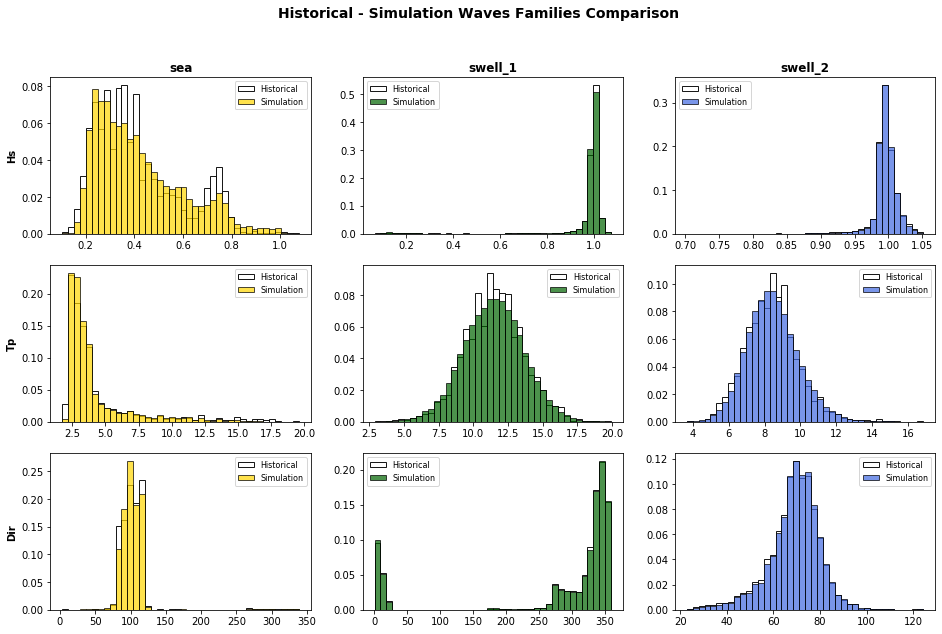

In [10]:
# --------------------------------------
# Compare waves families for reconstructed historical and simulated storms

# get storms from historical reconstruction
time_storms = HIST_C_h.where(HIST_C_h['max_storms']==True, drop=True).time
WVS_HIST_rec_s = WVS_HIST_rec.sel(time=time_storms)

# Select Simulation to plot storms
n_sim = 0
WVS_SIM_rec_n_s = WVS_SIM_rec.loc[WVS_SIM_rec['n_sim'] == n_sim]

# Plot reconstructed nearshore waves parameters distribution 
Plot_Waves_Histogram_FitSim(WVS_HIST_rec_s, WVS_SIM_rec_n_s);
